In [1]:
import cv2
import glob
import numpy as np
from matplotlib import pyplot as plt

Set the two images to be used in the test

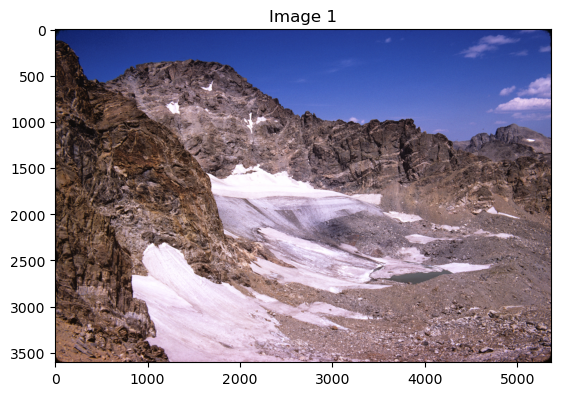

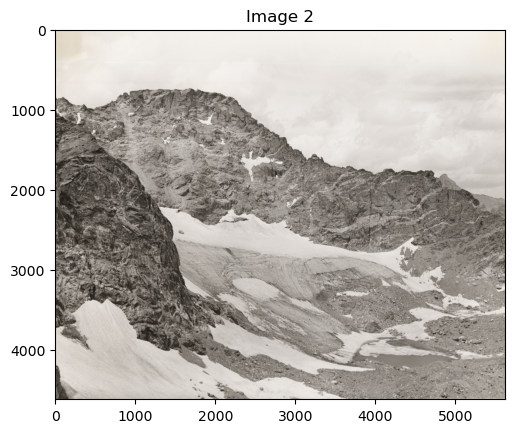

In [2]:
original_image_1 = cv2.cvtColor(cv2.imread('data/arapahoA9_13.tif'), cv2.COLOR_BGR2RGB)
original_image_2 = cv2.cvtColor(cv2.imread('data/arapaho1956081201.tif'), cv2.COLOR_BGR2RGB)

plt.imshow(original_image_1)
plt.title('Image 1')
plt.show()

plt.imshow(original_image_2)
plt.title('Image 2')
plt.show()

Set up a snow mask that can be used to differentiate snow from the rest of the image to help with registration

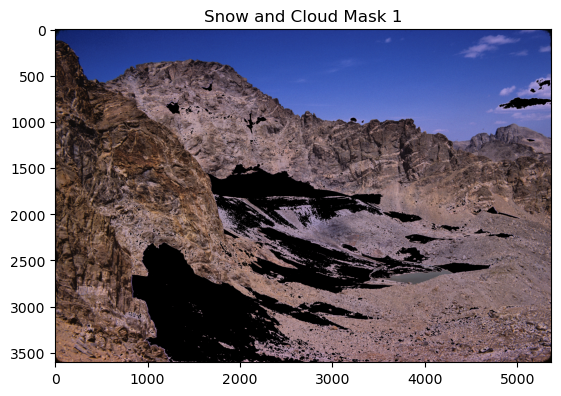

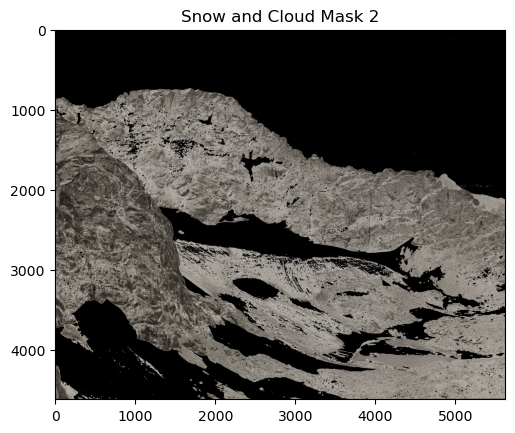

In [3]:
grey_image_1 = cv2.cvtColor(original_image_1, cv2.COLOR_BGR2GRAY)
grey_image_2 = cv2.cvtColor(original_image_2, cv2.COLOR_BGR2GRAY)

# Create a mask for snow in each image
snow_mask_1 = cv2.inRange(grey_image_1, 180, 255)
snow_mask_2 = cv2.inRange(grey_image_2, 180, 255)

# Set the values of image_1 and image_2 where there is snow to 0
snow_masked_image_2 = original_image_2.copy()
snow_masked_image_2[snow_mask_2 > 0] = 0

snow_masked_image_1 = original_image_1.copy()
snow_masked_image_1[snow_mask_1 > 0] = 0

# Display the snow masks
plt.imshow(snow_masked_image_1)
plt.title('Snow and Cloud Mask 1')
plt.show()

plt.imshow(snow_masked_image_2)
plt.title('Snow and Cloud Mask 2')
plt.show()

Detect and draw feature matches

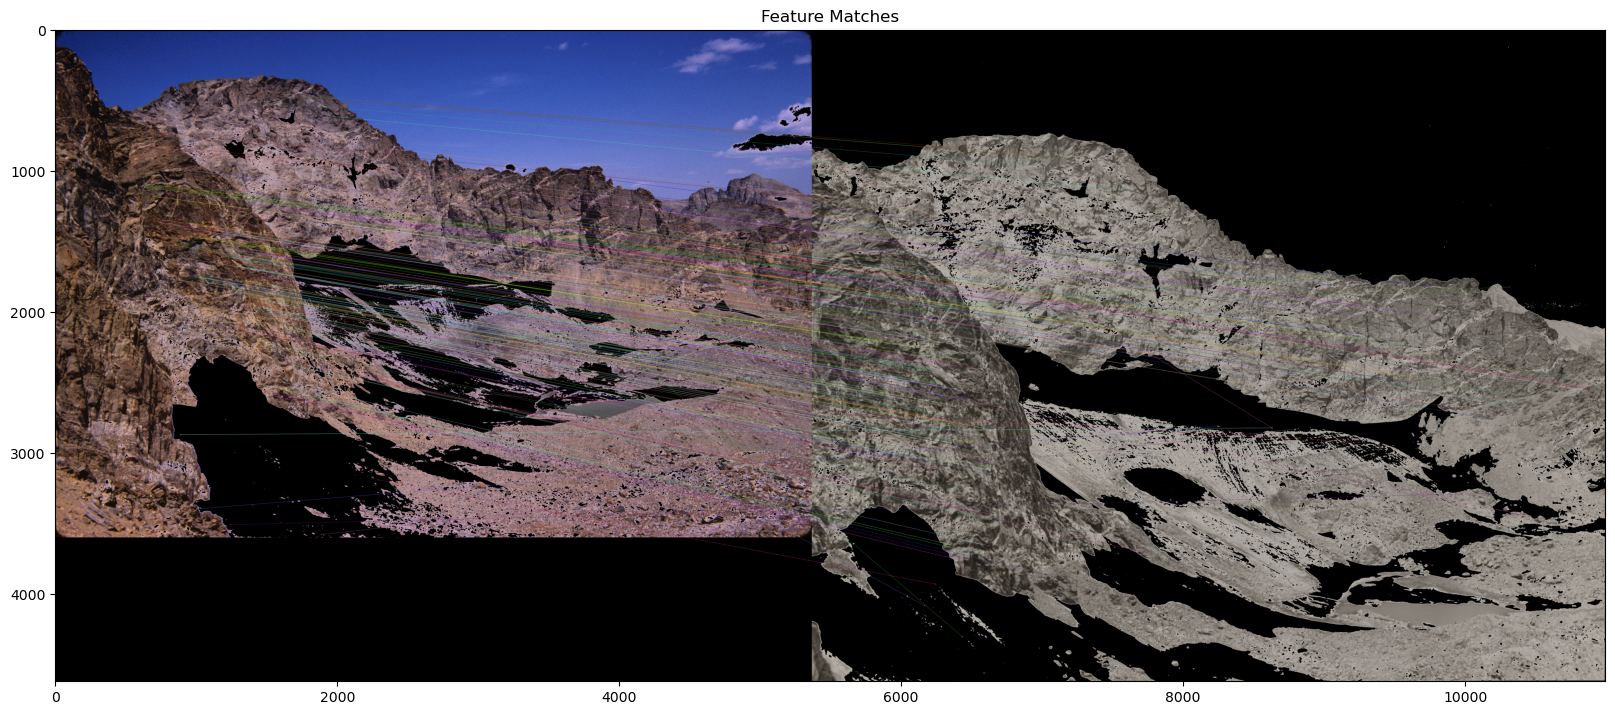

In [12]:
sift = cv2.SIFT_create()
keypoints_descriptors_1 = sift.detectAndCompute(snow_masked_image_1, None)
keypoints_descriptors_2 = sift.detectAndCompute(snow_masked_image_2, None)

# Match features between images
bf = cv2.BFMatcher()
matches = bf.knnMatch(keypoints_descriptors_1[1], keypoints_descriptors_2[1], k=2)

# Apply ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract location of good matches
src_pts = np.float32([keypoints_descriptors_1[0][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints_descriptors_2[0][m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# Draw matches
img_matches = cv2.drawMatches(snow_masked_image_1, keypoints_descriptors_1[0], snow_masked_image_2, keypoints_descriptors_2[0], good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.title('Feature Matches')
plt.show()

Find homography and rearrange image to match

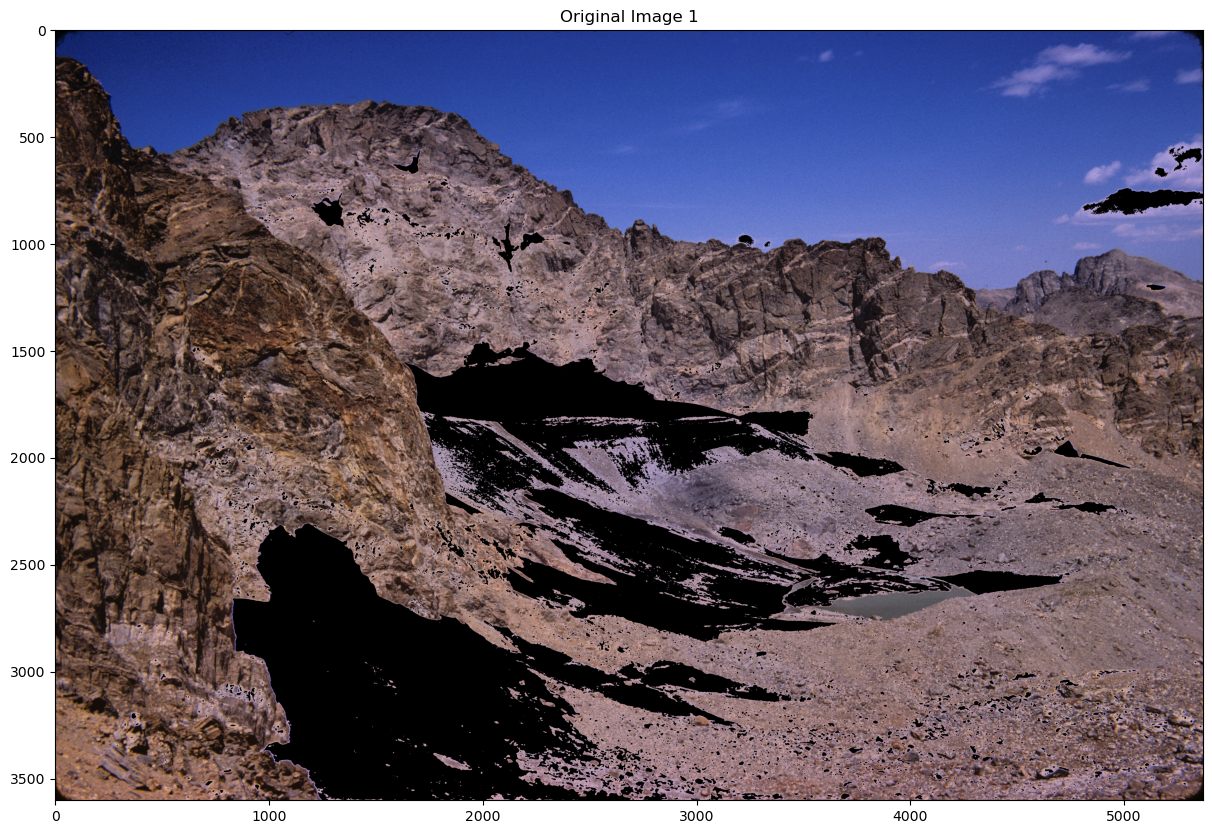

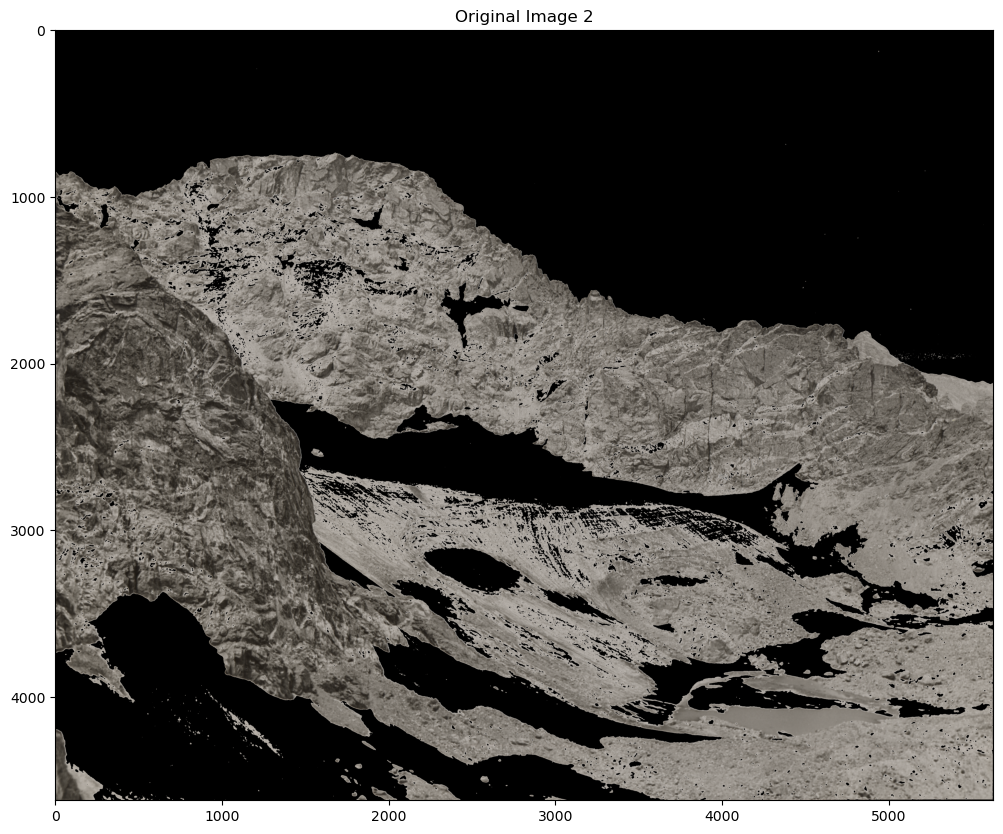

In [13]:
# Find homography matrix
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp images to align them
if len(snow_masked_image_1.shape) == 2:
    height, width = snow_masked_image_1.shape
else:
    height, width, _ = snow_masked_image_1.shape
aligned_image = cv2.warpPerspective(original_image_1, M, (width, height))
# Show original images side-by-side

plt.figure(figsize=(20, 10))
plt.imshow(snow_masked_image_1)
plt.title('Original Image 1')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(snow_masked_image_2)
plt.title('Original Image 2')
plt.show()

In [ ]:
import cv2
import numpy as np
from ipywidgets import IntSlider, interact
from ipycanvas import Canvas, hold_canvas

# Scale factor (change to your needs: 0.5 = 50% size)
scale = 0.25

aligned_image_resized = cv2.resize(aligned_image, (snow_masked_image_2.shape[1], snow_masked_image_2.shape[0]))

# Resize images for display (not the originals!)
img1_small = cv2.resize(original_image_2, (0, 0), fx=scale, fy=scale)
img2_small = cv2.resize(aligned_image_resized, (0, 0), fx=scale, fy=scale)

# Dimensions
h, w = img1_small.shape[:2]
canvas = Canvas(width=w, height=h)

def show_before_after(slider_value):
    with hold_canvas(canvas):
        canvas.clear()
        canvas.put_image_data(img1_small[:, :slider_value], x=0, y=0)
        canvas.put_image_data(img2_small[:, slider_value:], x=slider_value, y=0)

display(canvas)

interact(show_before_after, slider_value=IntSlider(min=0, max=w, value=w // 2, step=1))

Canvas(height=1155, width=1406)

interactive(children=(IntSlider(value=703, description='slider_value', max=1406), Output()), _dom_classes=('wi…

<function __main__.show_before_after(slider_value)>

Thoughts on improvements;
 - Detect horizon line and use it to both mask changes in the sky (eg clouds) as well as to enhance the alignment (eg ridgeline should look the same from similar perspectives)
 - Evaluate whether the matching was a success